# Von Frey XO sequence calculator and plotter

### This R script is developend in Andrei V. Chernov's Lab at the University of California San Diego in 2022.

#### Version 0.1. https://github.com/chernov-lab/VonFreyTest

#### The script is based on experimental work in Drs. T.L. Yaksch (UCSD) and V.I. Shubayev (UCSD).

##### Parametric data were derived from: 
S R Chaplan  1 , F W Bach, J W Pogrel, J M Chung, T L Yaksh
Quantitative assessment of tactile allodynia in the rat paw
J Neurosci Methods, 1994 Jul;53(1):55-63. doi: 10.1016/0165-0270(94)90144-9.


## Provide file name of the excel file that includes **data** and **meta** tabs
### The **data** tab stores observation and last filament results
### The **meta** tab establishes comparison pairs

In [65]:
data_file <- "test_data.xlsx"  # <<<- provide excel file name with VF data. File should be uploaded in the main folder

## Set up test parameters:

In [66]:
paw <- 'LEFT' #'RIGHT',  # define paw to use
sex <- "female"  # define sex of animals if needed. Assign "" is sex is not defined
species <- "rat" # define species of animal rat or mouse
res_file <- paste('result', data_file, sep='.')  # result file
post_hoc_method <- "bonferroni" # Allowed values include "holm", "hochberg", "hommel", "bonferroni", "BH", "BY", "fdr", "none". If you don't want to adjust the p value (not recommended), use p.adjust.method = "none".
label_id <- F # set TRUE if want to label animal IDs below threshold

In [67]:
library(readr)
library(ggplot2)
library(ggpubr)
library(ggiraphExtra)
library(dplyr)
library(tidyverse)
library(rstatix)
library(DescTools)
library(readxl)
library(writexl)
library(lubridate)
library(emmeans)
library(ggpubr)

### Define some custom functions

In [68]:
`%notin%` <- Negate(`%in%`)

acPage = function(w1=12, h1=6, r1=1, c1=1, m1=2, m2=2, m3=2, m4=2){
  options(repr.plot.width=w1, repr.plot.height= h1) 
  par(mfrow=c(r1,c1), mar=c(m1,m2,m3,m4))
}

### Set on-screen plotting parameters

In [69]:
acPage()

In [70]:
# Folder definitions
main_folder = ""
data_folder <- "files"
par_folder <- "parameters"

sex <- toupper(sex)

if (species == "rat"){
    pain_threshold <- 5
    max_res <- 15
}

### Read species specific parameters 
### Perform Von Frey Test calculations

In [71]:
XO_file <- paste(species, "final.previous.filaments.XO.csv", sep='.')
stat_file <- paste(species, "observation-statistics.csv", sep='.')

observation_table <- read.csv(file.path(par_folder, stat_file), row.names=1, stringsAsFactors=FALSE)
XO.table <- read.csv(file.path(par_folder, XO_file), row.names=1, stringsAsFactors=FALSE) #, col_types = "nnn")

VonFrey = function(obs='', last=0){
    obs <- toupper(obs)
    res <- 0
    if (obs == '' | last == 0) { return (-1)} 
    else if (obs == 'OOOOO' & last == 5.18) { res <- max_res } 
    else if (obs == 'XXXX' & last == 3.61) { res <- 0.2 }
    else if (length(which(rownames(XO.table) == last)) == 0 | length(which(rownames(observation_table) == obs))== 0) { return (-1)}
    else {
    a <- substr(obs, nchar(obs)-1, nchar(obs)-1)
    prev <- XO.table[which(rownames(XO.table) == last), a]
    dif <- abs(last - prev)
    p50 <- last + dif * observation_table[which(rownames(observation_table) == obs),'STATISTIC']
    res <- (10**p50)/10000
    if (res > 15) { res <- max_res }
    if (res < 0.2) { res <- 0.20 }
    return(as.numeric(sprintf("%.2f", res)))
    }
}
TruncateObservation = function(obs='', met=2){
    obs <- toupper(obs)
    if (obs == '') { return ("") } 
    if (met == 2) { return (obs) }
    if (met == 1) {  # Jenny's short method
    len <- nchar(obs)  
    Xpos <- StrPos(obs, 'X') 
    if (is.na(Xpos)) { return (obs) }   
    obs1 <- substr(obs, Xpos, len)
 
    return (obs1)
    }
}

## Read DATA and META files from main folder

In [72]:
x <- readxl::read_excel(data_file, sheet = "data") 
meta <- readxl::read_excel(data_file, sheet = "meta")

In [73]:
x <- x %>% rename_with(toupper)
meta <- meta %>% rename_with(toupper)

# convert key parameters to uppercase
x <- x %>% dplyr::mutate (
                DATE = ymd(DATE),
                SEX = toupper(SEX), 
                OBSERVATION = toupper(OBSERVATION),
                PAW = toupper(PAW))
x <- x %>% dplyr::arrange(SEX, TIMEPOINT, PAW)
head(x)
head(meta)

DATE,SPECIES,SEX,GROUP,ANIMAL_ID,CAGE,NOTCH,PAW,TIMEPOINT,OBSERVATION,LAST
<date>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>
2022-01-13,RAT,FEMALE,A,AC225,1,L,LEFT,0,OOOOXXOXO,4.74
2022-01-13,RAT,FEMALE,A,AC226,1,R,LEFT,0,OOOOO,5.18
2022-01-13,RAT,FEMALE,A,AC227,1,N,LEFT,0,OOOOXOXOX,5.18
2022-01-14,RAT,FEMALE,A,AC340,7,L,LEFT,0,OOOOXXOXO,4.74
2022-01-14,RAT,FEMALE,A,AC341,7,R,LEFT,0,OOOOXXOXO,4.74
2022-01-14,RAT,FEMALE,A,AC342,7,N,LEFT,0,OOOOXOXXO,4.74


COMPARISON,TREATMENT,REFERENCE,SPECIES,SEX
<dbl>,<chr>,<chr>,<chr>,<chr>
1,B,E,RAT,FEMALE
2,B,A,RAT,FEMALE
3,C,E,RAT,FEMALE
4,C,A,RAT,FEMALE
5,D,E,RAT,FEMALE
6,D,A,RAT,FEMALE


### filter by specific sex if **sex** is assigned

In [74]:
if (sex != ""){ x <- x %>% filter (SEX == sex) }

### Calculate **Von Frey Test** values

In [75]:
x <- x %>% dplyr::mutate(RESULT = mapply(VonFrey, OBSERVATION, LAST))

In [76]:
head(x, 5)

DATE,SPECIES,SEX,GROUP,ANIMAL_ID,CAGE,NOTCH,PAW,TIMEPOINT,OBSERVATION,LAST,RESULT
<date>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
2022-01-13,RAT,FEMALE,A,AC225,1,L,LEFT,0,OOOOXXOXO,4.74,8.34
2022-01-13,RAT,FEMALE,A,AC226,1,R,LEFT,0,OOOOO,5.18,15.00
2022-01-13,RAT,FEMALE,A,AC227,1,N,LEFT,0,OOOOXOXOX,5.18,11.66
2022-01-14,RAT,FEMALE,A,AC340,7,L,LEFT,0,OOOOXXOXO,4.74,8.34
2022-01-14,RAT,FEMALE,A,AC341,7,R,LEFT,0,OOOOXXOXO,4.74,8.34


### Check for errors reported by Von Frey calculator
#### Negative RESULTs (-1) indicate an error most likely related to incorrect XO data entry

In [77]:
x %>% filter(RESULT < 0)

DATE,SPECIES,SEX,GROUP,ANIMAL_ID,CAGE,NOTCH,PAW,TIMEPOINT,OBSERVATION,LAST,RESULT
<date>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>


### Prepare dataset for ANOVA analysis and plotting

In [78]:
x <- x %>% filter(RESULT > 0)
lp_x_names <- c('SEX', 'GROUP', 'PAW', 'TIMEPOINT', 'RESULT', 'ANIMAL_ID')
lp_meta_names <- c('COMPARISON', 'TREATMENT', 'REFERENCE')

In [79]:
lp <- x %>% 
    select(all_of(lp_x_names)) %>% 
        mutate(DAY = TIMEPOINT, 
               TIMEPOINT = as.integer(TIMEPOINT),
               DAY = factor(TIMEPOINT),
               GROUP = factor(GROUP),
               ID = row_number()) %>% 
        print

# A tibble: 450 × 8
   SEX    GROUP PAW   TIMEPOINT RESULT ANIMAL_ID DAY      ID
   <chr>  <fct> <chr>     <int>  <dbl> <chr>     <fct> <int>
 1 FEMALE A     LEFT          0   8.34 AC225     0         1
 2 FEMALE A     LEFT          0  15    AC226     0         2
 3 FEMALE A     LEFT          0  11.7  AC227     0         3
 4 FEMALE A     LEFT          0   8.34 AC340     0         4
 5 FEMALE A     LEFT          0   8.34 AC341     0         5
 6 FEMALE A     LEFT          0   9.49 AC342     0         6
 7 FEMALE B     LEFT          0   8.34 AC228     0         7
 8 FEMALE B     LEFT          0  13.8  AC229     0         8
 9 FEMALE B     LEFT          0  15    AC330     0         9
10 FEMALE B     LEFT          0  11.7  AC343     0        10
# … with 440 more rows


In [80]:
print(meta)

# A tibble: 6 × 5
  COMPARISON TREATMENT REFERENCE SPECIES SEX   
       <dbl> <chr>     <chr>     <chr>   <chr> 
1          1 B         E         RAT     FEMALE
2          2 B         A         RAT     FEMALE
3          3 C         E         RAT     FEMALE
4          4 C         A         RAT     FEMALE
5          5 D         E         RAT     FEMALE
6          6 D         A         RAT     FEMALE


### Set up comparison pairs

In [81]:
meta <- meta %>% mutate(COMPARISON = mapply(sprintf, "%s-%s", TREATMENT, REFERENCE)) %>% print

# A tibble: 6 × 5
  COMPARISON TREATMENT REFERENCE SPECIES SEX   
  <chr>      <chr>     <chr>     <chr>   <chr> 
1 B-E        B         E         RAT     FEMALE
2 B-A        B         A         RAT     FEMALE
3 C-E        C         E         RAT     FEMALE
4 C-A        C         A         RAT     FEMALE
5 D-E        D         E         RAT     FEMALE
6 D-A        D         A         RAT     FEMALE


In [82]:
comparisons <- meta %>% select (TREATMENT, REFERENCE) %>% t %>% as_tibble %>% as.list %>% print

$V1
[1] "B" "E"

$V2
[1] "B" "A"

$V3
[1] "C" "E"

$V4
[1] "C" "A"

$V5
[1] "D" "E"

$V6
[1] "D" "A"



### Filter by LEFT or RIGHT paw

In [83]:
if (paw != "") { lp <- lp %>% filter(PAW == paw) }

In [84]:
min_res <- lp %>% select (RESULT) %>% min %>% print
max_res <- lp %>% select (RESULT) %>% max %>% print

[1] 0.88
[1] 15


## Summary statistics
Compute some summary statistics (count, mean and sd) of the variable weight organized by groups:

# Two-way ANOVA

## Summary statistics
Compute the mean and the SD (standard deviation) of the score by groups:

In [85]:
lp_stat <- lp %>%
  group_by(GROUP, DAY) %>%
        get_summary_stats(RESULT, type = "mean_se") %>% 
        mutate (TIMEPOINT = as.numeric(strtoi(DAY))) %>% 
        print

# A tibble: 40 × 7
   GROUP DAY   variable     n  mean    se TIMEPOINT
   <fct> <fct> <chr>    <dbl> <dbl> <dbl>     <dbl>
 1 A     0     RESULT       6 10.2  1.10          0
 2 A     1     RESULT       6  5.08 1.17          1
 3 A     3     RESULT       6  3.71 0.73          3
 4 A     5     RESULT       6  4.75 0.453         5
 5 A     7     RESULT       6  7.97 1.06          7
 6 A     13    RESULT       6  5.96 1.35         13
 7 A     18    RESULT       6  8.44 1.96         18
 8 A     21    RESULT       3  8.06 2.90         21
 9 B     0     RESULT       6 11.8  1.41          0
10 B     1     RESULT       6  5.08 1.27          1
# … with 30 more rows


## Visualization
Create a box plot of the score by gender levels, colored by education levels:

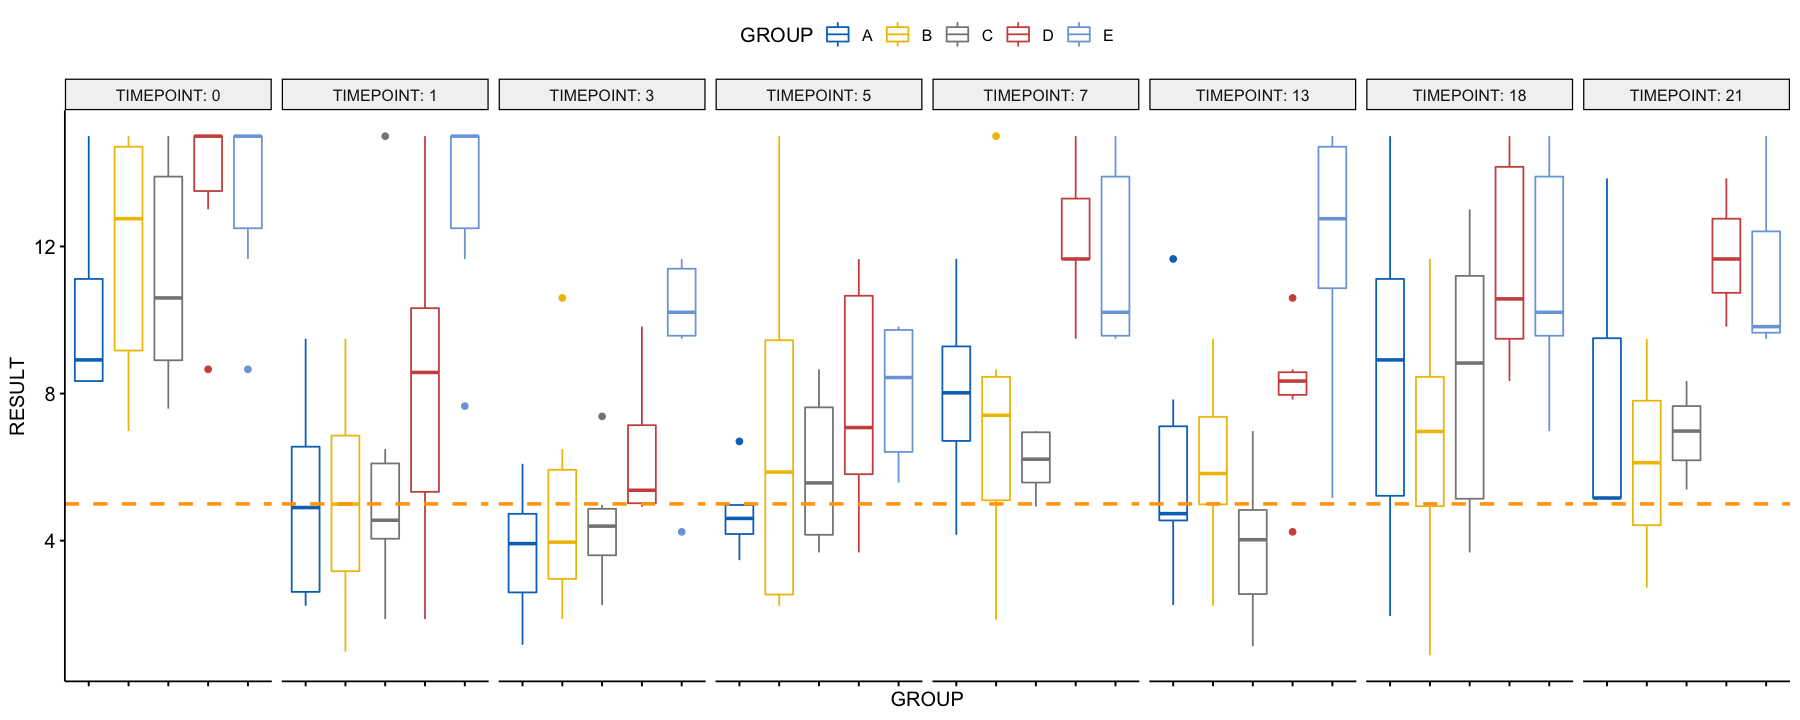

In [86]:
acPage(w1=15, h1=6)
bxp <- lp %>% ggboxplot(
    x = "GROUP", y = "RESULT",
    color = "GROUP", 
    palette = "jco",
    ) +
    rremove("x.text") +
    geom_hline(yintercept=5, linetype="dashed", color = "orange", size=1) +
    facet_grid( ~ TIMEPOINT, labeller = "label_both")

plot(bxp)

In [87]:
lp_outs <- lp %>%
  group_by(GROUP, DAY) %>%
    identify_outliers(RESULT) %>% 
        filter(is.extreme == TRUE) %>% print()

lp <- lp %>% anti_join(lp_outs, by = "ID") %>% print()

# A tibble: 4 × 10
  GROUP DAY   SEX   PAW   TIMEPOINT RESULT ANIMAL_ID    ID is.outlier is.extreme
  <fct> <fct> <chr> <chr>     <int>  <dbl> <chr>     <int> <lgl>      <lgl>     
1 C     1     FEMA… LEFT          1  15    AC333        75 TRUE       TRUE      
2 D     0     FEMA… LEFT          0   8.66 AC336        21 TRUE       TRUE      
3 D     13    FEMA… LEFT         13   4.24 AC336       312 TRUE       TRUE      
4 D     13    FEMA… LEFT         13  10.6  AC349       325 TRUE       TRUE      
# A tibble: 221 × 8
   SEX    GROUP PAW   TIMEPOINT RESULT ANIMAL_ID DAY      ID
   <chr>  <fct> <chr>     <int>  <dbl> <chr>     <fct> <int>
 1 FEMALE A     LEFT          0   8.34 AC225     0         1
 2 FEMALE A     LEFT          0  15    AC226     0         2
 3 FEMALE A     LEFT          0  11.7  AC227     0         3
 4 FEMALE A     LEFT          0   8.34 AC340     0         4
 5 FEMALE A     LEFT          0   8.34 AC341     0         5
 6 FEMALE A     LEFT          0   9.49 AC342    

### Build the linear model

In [88]:
model  <- lm(RESULT ~ GROUP * DAY, data = lp)

### Create a QQ plot of residuals

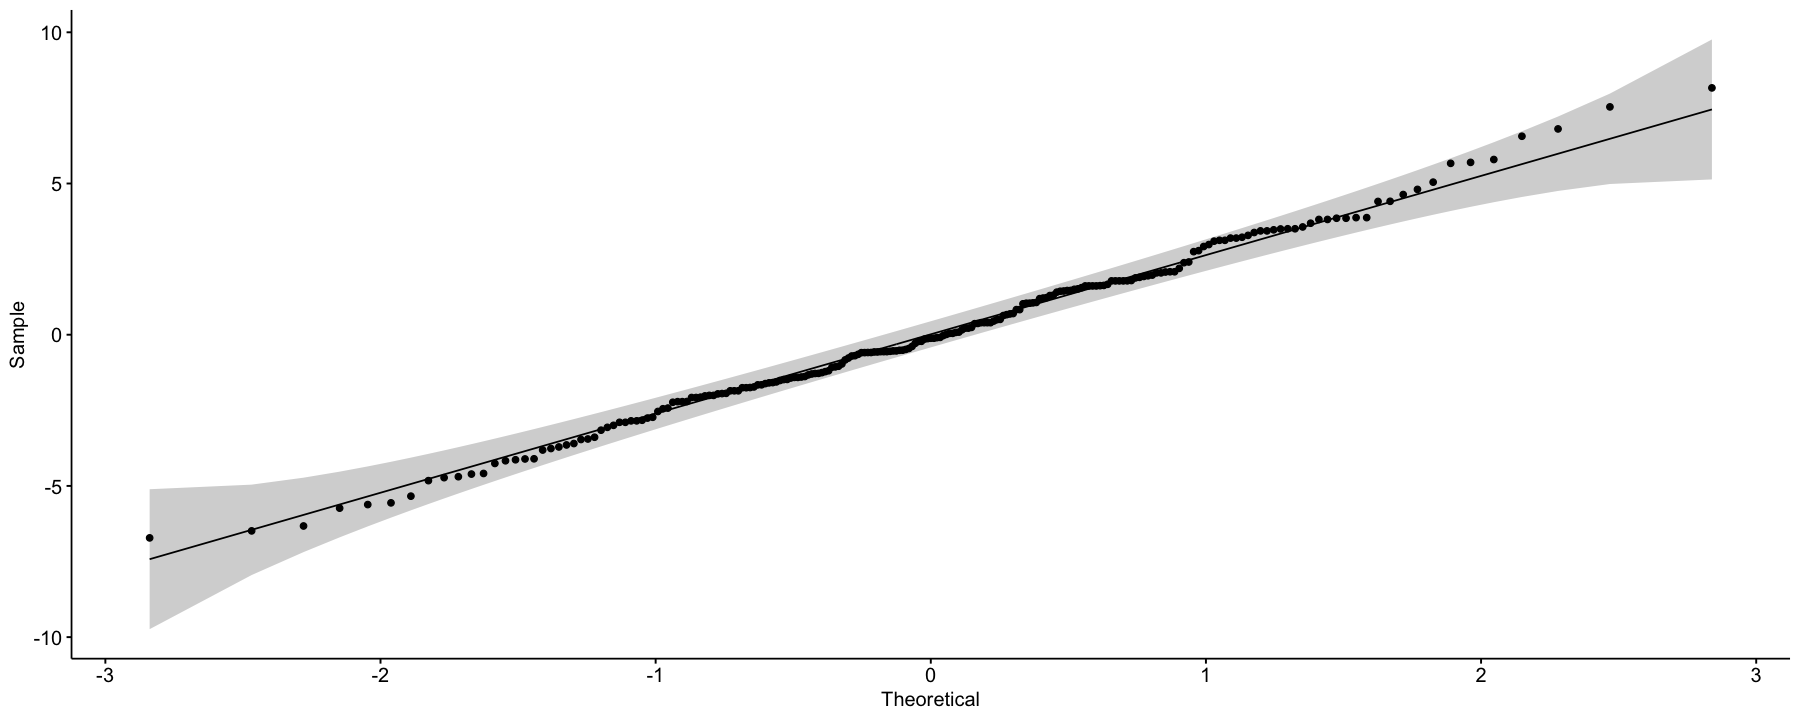

In [89]:
model %>% residuals %>% ggqqplot

### Compute Shapiro-Wilk test of normality

In [90]:
model %>% residuals %>% shapiro_test

variable,statistic,p.value
<chr>,<dbl>,<dbl>
.,0.9947944,0.649191


In [91]:
lp %>% group_by(GROUP) %>% shapiro_test(RESULT) %>% print

# A tibble: 5 × 4
  GROUP variable statistic        p
  <fct> <chr>        <dbl>    <dbl>
1 A     RESULT       0.940 0.0216  
2 B     RESULT       0.943 0.0269  
3 C     RESULT       0.928 0.00896 
4 D     RESULT       0.944 0.0411  
5 E     RESULT       0.886 0.000351


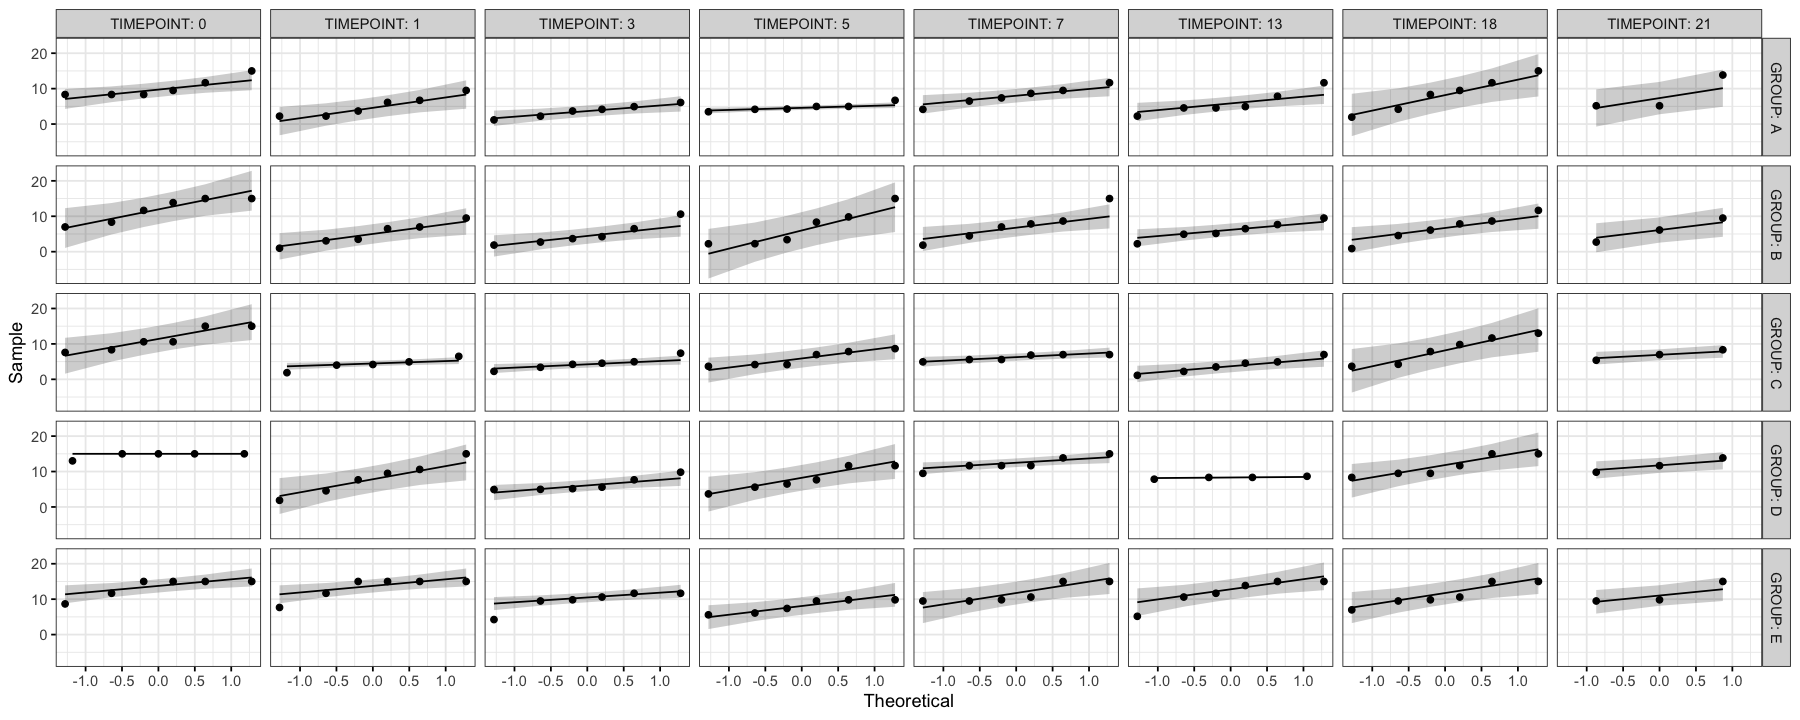

In [92]:
ggqqplot(lp, "RESULT", ggtheme = theme_bw()) +
  facet_grid( GROUP ~ TIMEPOINT, labeller = "label_both")

### Calculate ANOVA statistics table with post hoc corrections 

In [93]:
pwc <- lp %>% 
  group_by(DAY) %>%
      emmeans_test(RESULT ~ GROUP, model = model, 
            comparisons = comparisons,
                   p.adjust.method = post_hoc_method) 

### List most significant differences between groups

In [94]:
pwc %>% filter(p.adj < 0.1) %>% arrange (p.adj) %>% print

# A tibble: 11 × 10
   DAY   term  .y.    group1 group2    df statistic       p   p.adj p.adj.signif
   <chr> <chr> <chr>  <chr>  <chr>  <dbl>     <dbl>   <dbl>   <dbl> <chr>       
 1 1     GROUP RESULT C      E        181     -4.90 2.15e-6 1.29e-5 ****        
 2 1     GROUP RESULT B      E        181     -4.68 5.54e-6 3.32e-5 ****        
 3 13    GROUP RESULT C      E        181     -4.60 7.95e-6 4.77e-5 ****        
 4 13    GROUP RESULT B      E        181     -3.39 8.67e-4 5.20e-3 **          
 5 7     GROUP RESULT C      E        181     -3.12 2.12e-3 1.27e-2 *           
 6 3     GROUP RESULT C      E        181     -2.94 3.67e-3 2.20e-2 *           
 7 1     GROUP RESULT D      E        181     -2.89 4.30e-3 2.58e-2 *           
 8 3     GROUP RESULT B      E        181     -2.67 8.20e-3 4.92e-2 *           
 9 18    GROUP RESULT B      E        181     -2.61 9.84e-3 5.91e-2 ns          
10 7     GROUP RESULT D      A        181      2.44 1.55e-2 9.29e-2 ns          
11 0    

### Add formatted P-value for graphics

In [95]:
pwc$p.format <- p_format(pwc$p, accuracy = 0.0001, leading.zero = FALSE)
head(pwc)

DAY,term,.y.,group1,group2,df,statistic,p,p.adj,p.adj.signif,p.format
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0,GROUP,RESULT,B,E,181,-0.9102395,0.36390680,1.00000000,ns,.36391
0,GROUP,RESULT,B,A,181,0.9265451,0.35539655,1.00000000,ns,.3554
0,GROUP,RESULT,C,E,181,-1.2651273,0.20745201,1.00000000,ns,.20745
0,GROUP,RESULT,C,A,181,0.5716572,0.56826343,1.00000000,ns,.56826
0,GROUP,RESULT,D,E,181,0.6668678,0.50570578,1.00000000,ns,.50571
0,GROUP,RESULT,D,A,181,2.4181732,0.01658982,0.09953894,ns,.01659


## Plot all data on one graph

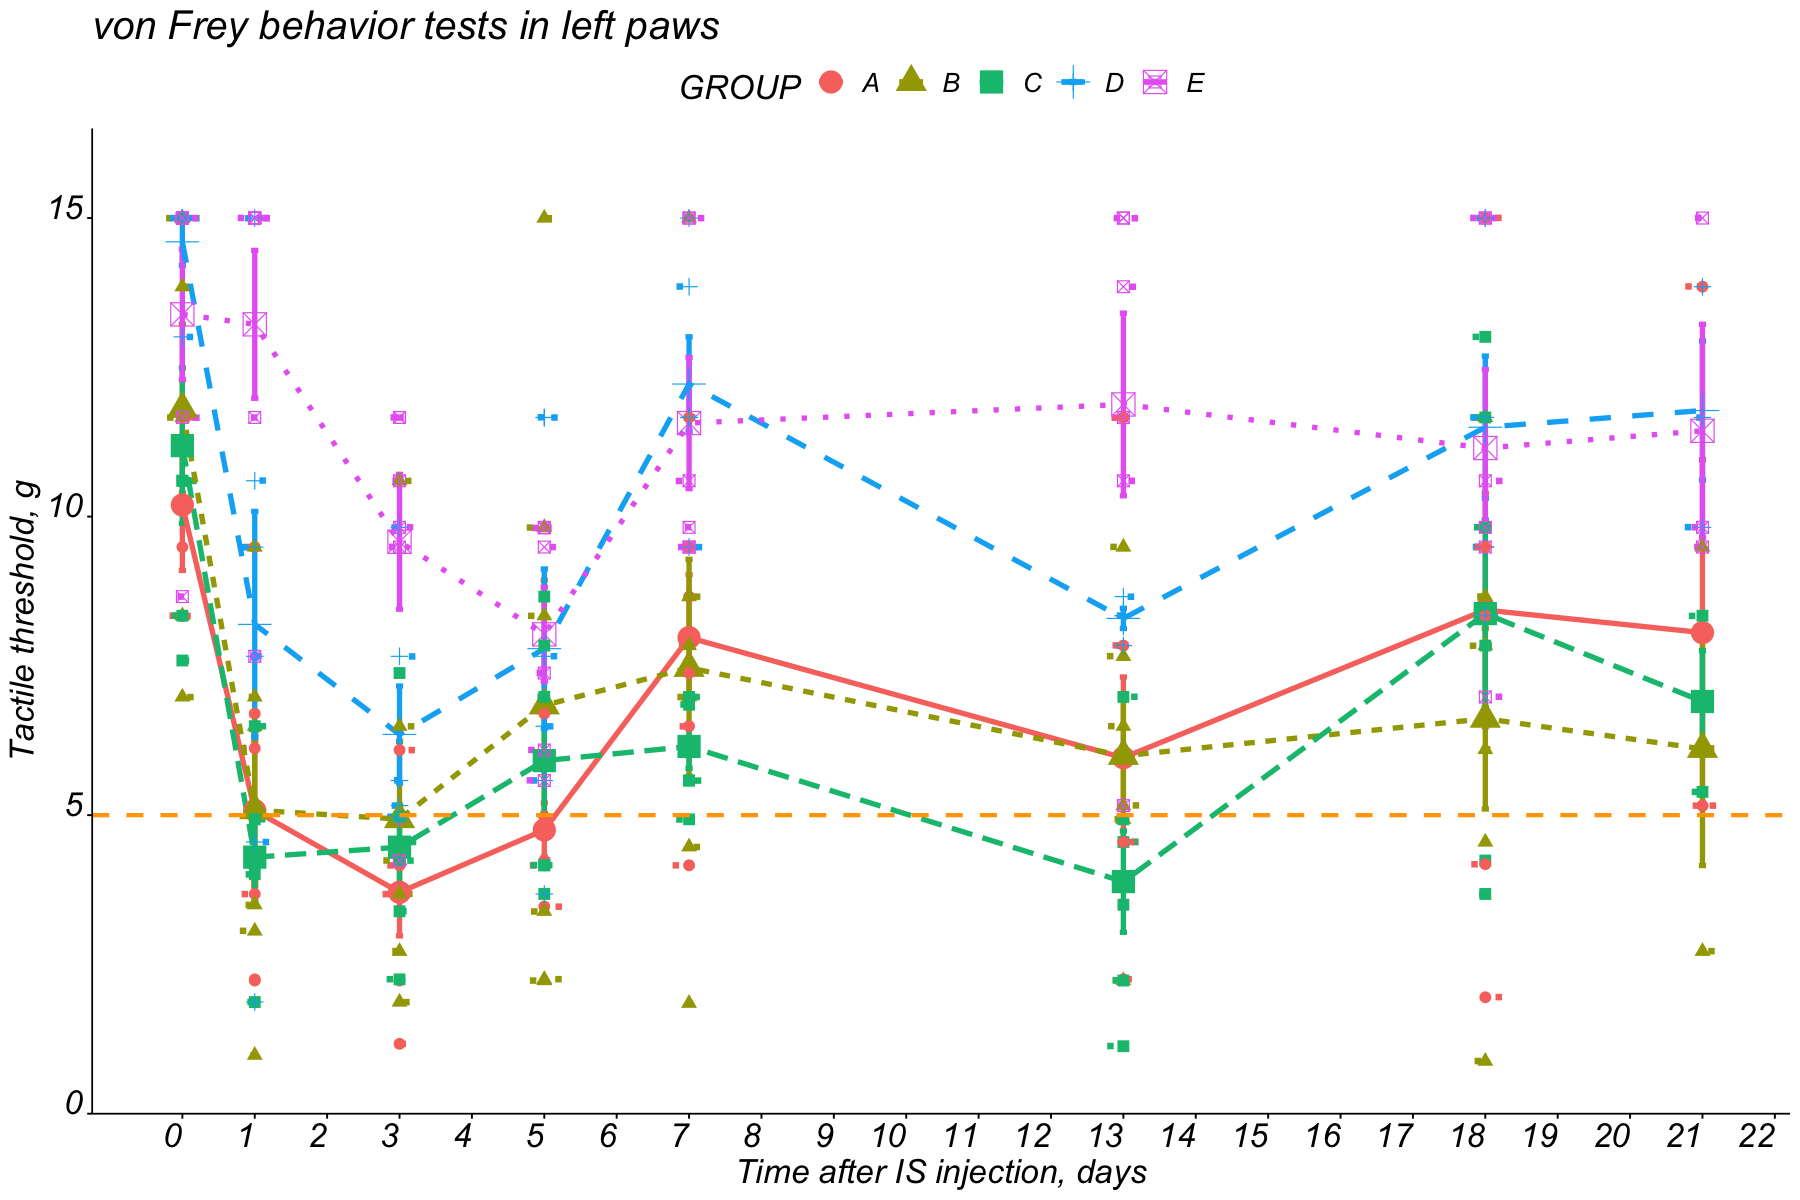

In [96]:
acPage(w1=15, h1=10)

x_max <- max(lp$TIMEPOINT) + 1
days <- order(unique(lp$TIMEPOINT), decreasing=F)

p <- ggline(lp, 
            x = "TIMEPOINT",
            y = "RESULT", 
            size = 1.5,            
            color = "GROUP",
            shape = "GROUP",
            point.size = 5,
            linetype = "GROUP",
            ylim = c(0, max_res),
            add = c("mean_se", "jitter" ),
            add.params = list(width = 0.1, shape = 15),
            palette = "GROUP"
            )  +
    geom_point(size = 3, aes(color = GROUP, shape = GROUP)) +
    xlab("Time after IS injection, days") +
    ylab("Tactile threshold, g") +
    ggtitle( sprintf( "von Frey behavior tests in %s paws", tolower (paw))) +
    theme(text = element_text(size=20, color = "black", angle = 0, hjust = .5, vjust = 0, face = "italic"),
    axis.text.x = element_text(hjust=1)) +
    geom_hline(yintercept=5, linetype="dashed", color = "orange", size=1.2) +
    scale_y_continuous(breaks= 0 : round(max_res) * max_res/3, expand = expansion(mult = c(0, 0.1))  ) +
    scale_x_continuous(breaks= 0 : x_max * 1) 
plot(p)

In [97]:
### Plot this graph into a PDF file

In [98]:
pdf(sprintf("vonFrey plot.pdf"), width = 15, height = 10)
plot(p)
dev.off()

pdf 
  2

### Ensure X axis coordinates correctly mapped

In [99]:
pwc <- pwc %>% mutate(x = as.numeric(DAY), xmin = as.numeric(strtoi(DAY)), xmax = as.numeric(strtoi(DAY)) + 0.32) %>% arrange(x)

## Plot graphs for individual comparisons and save in PDF files

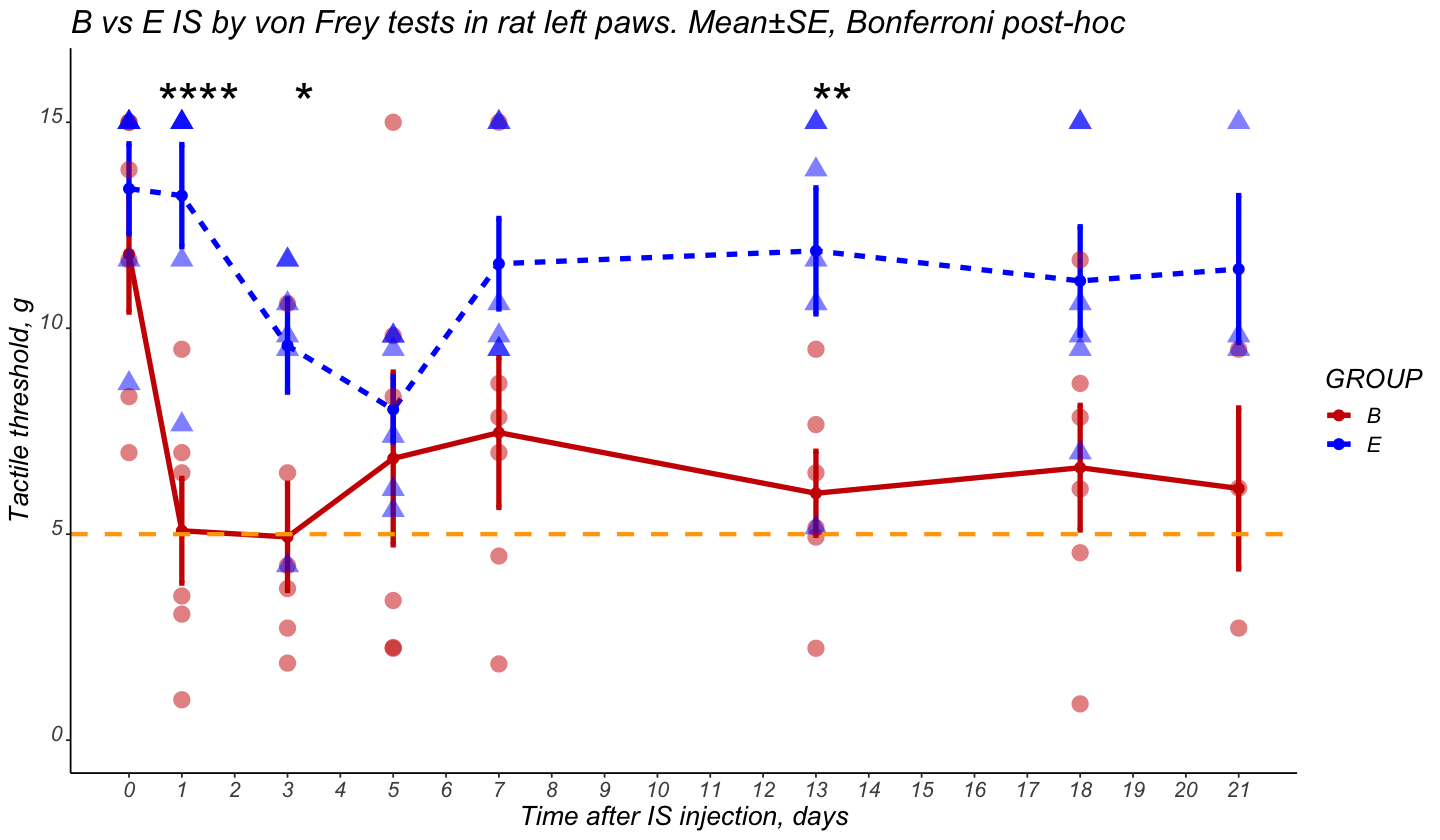

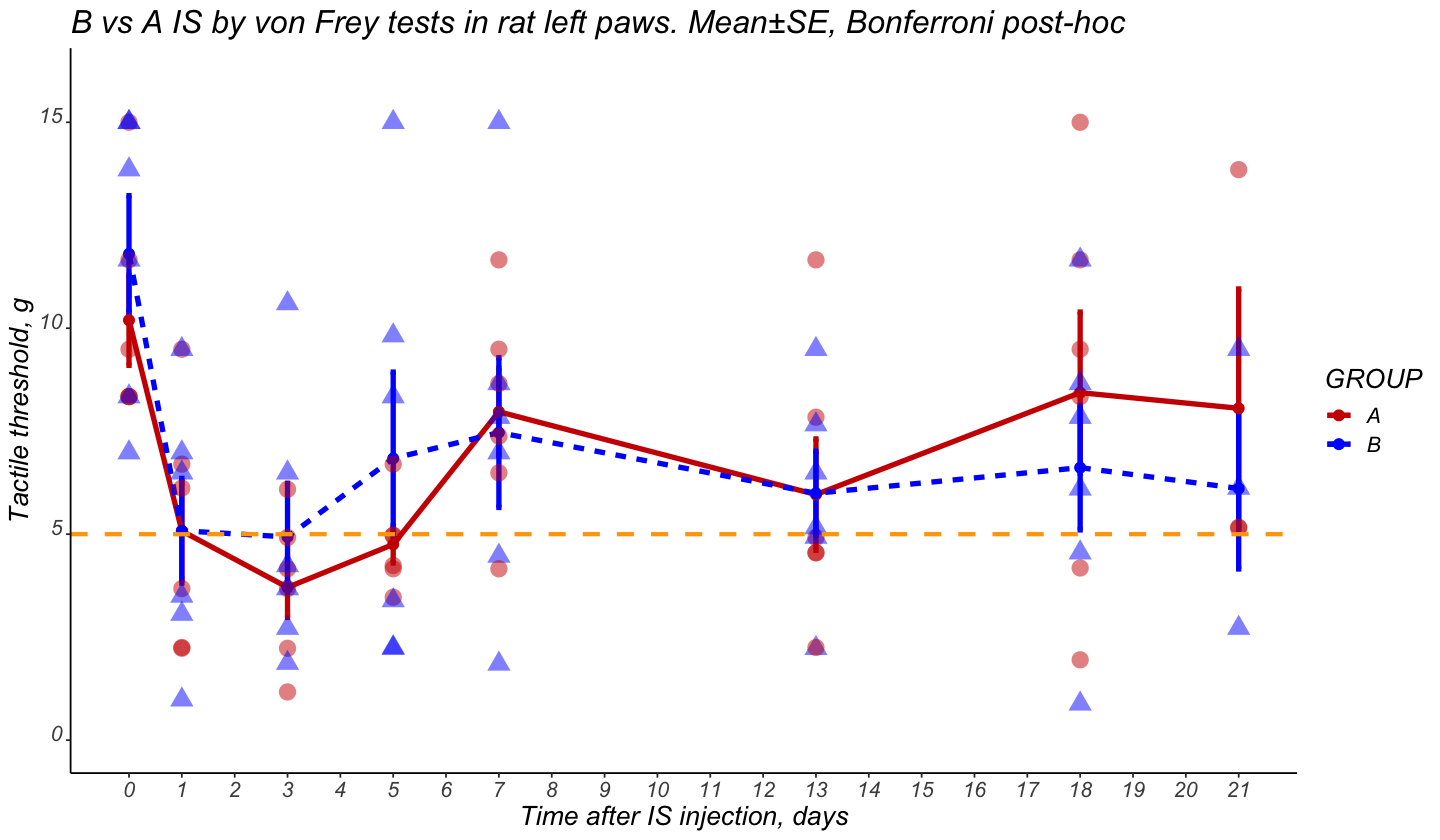

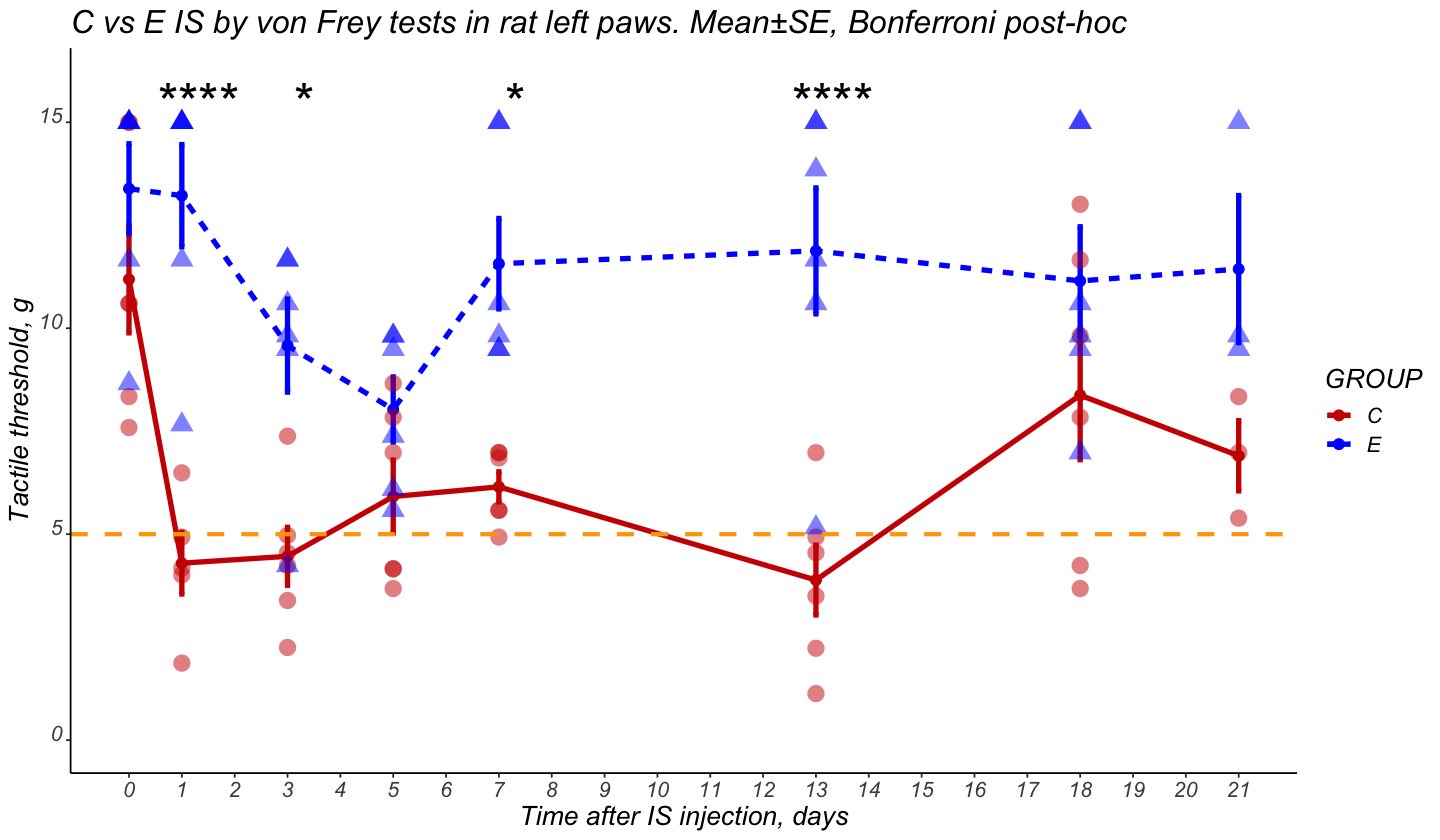

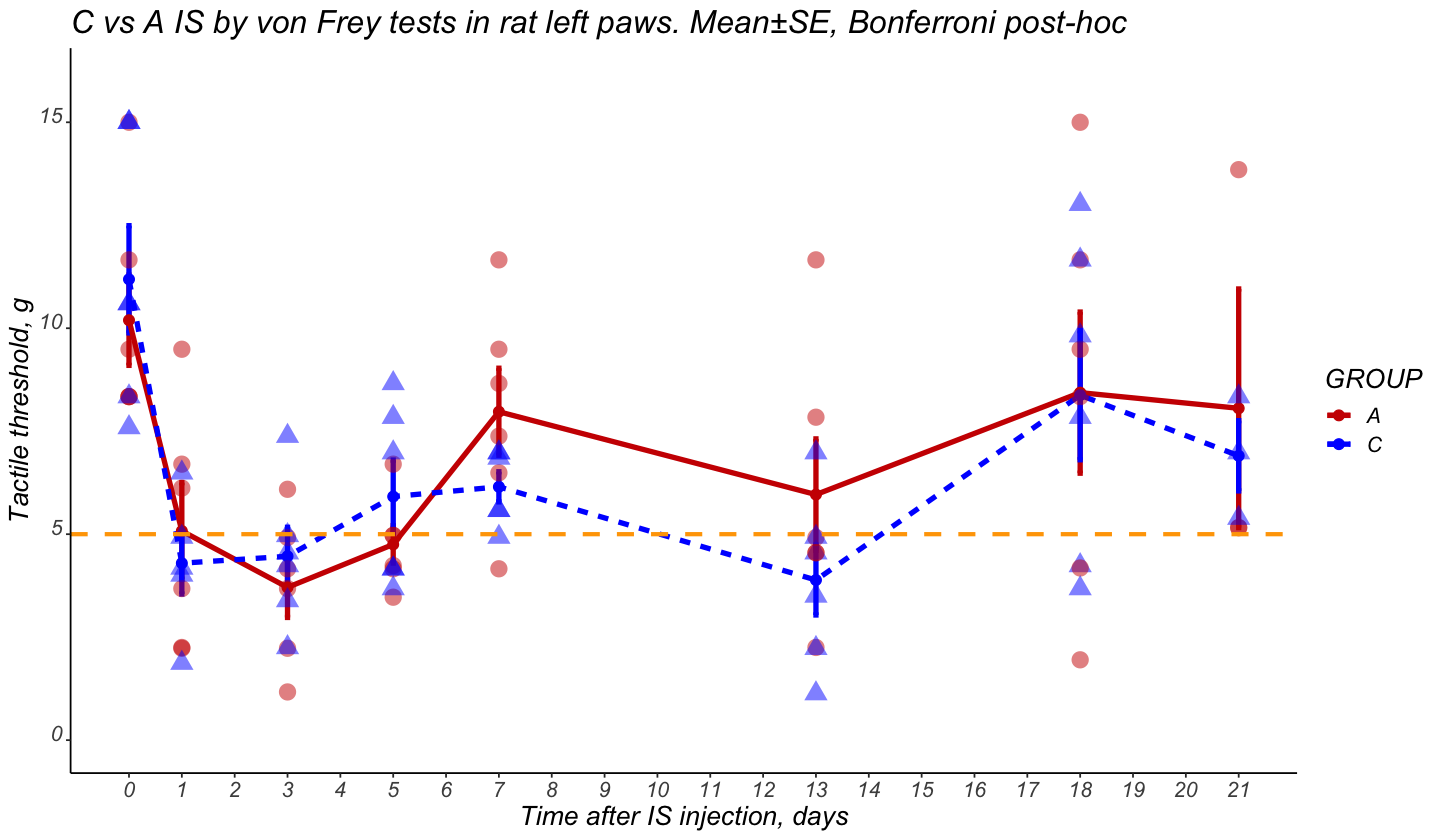

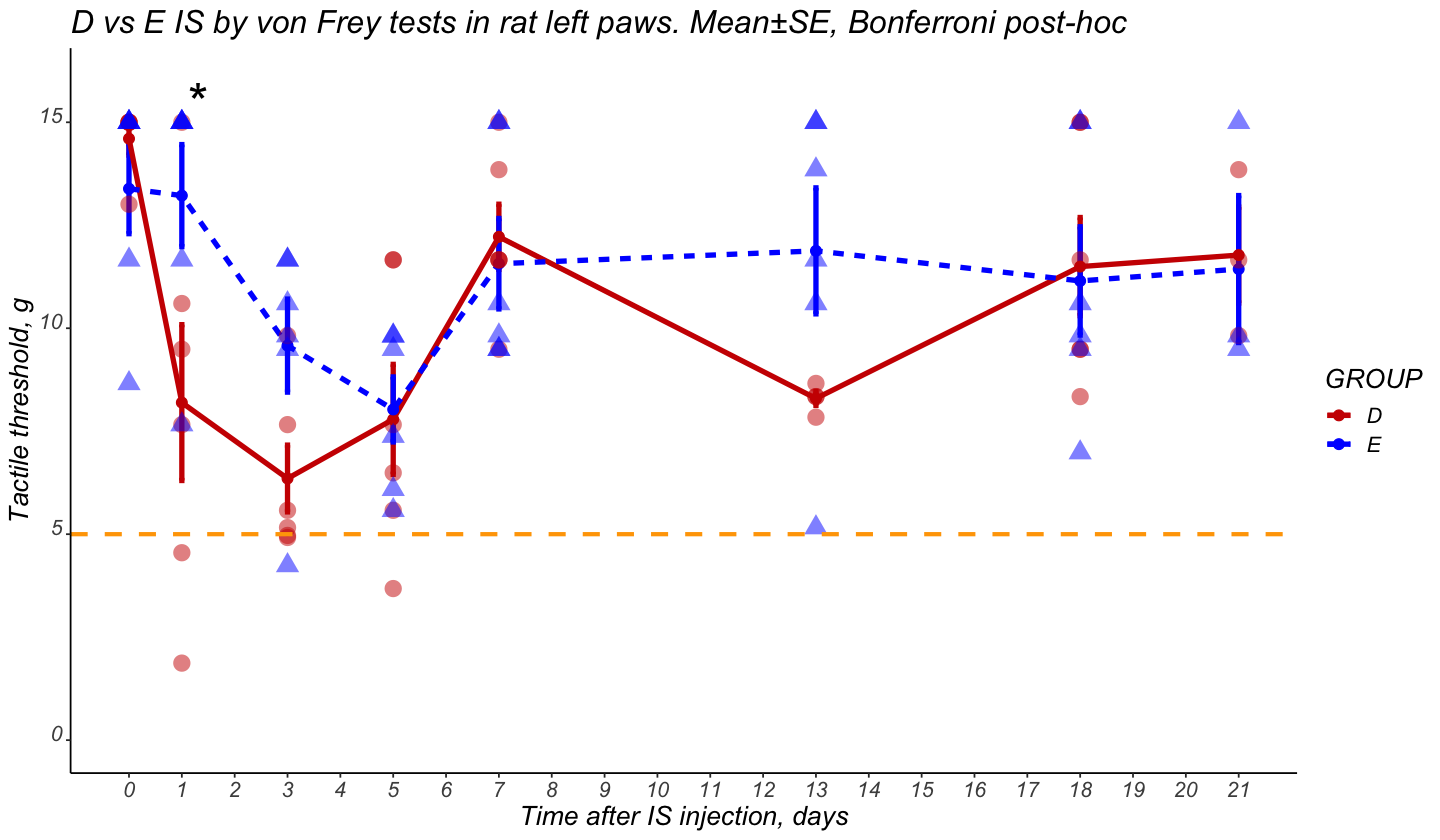

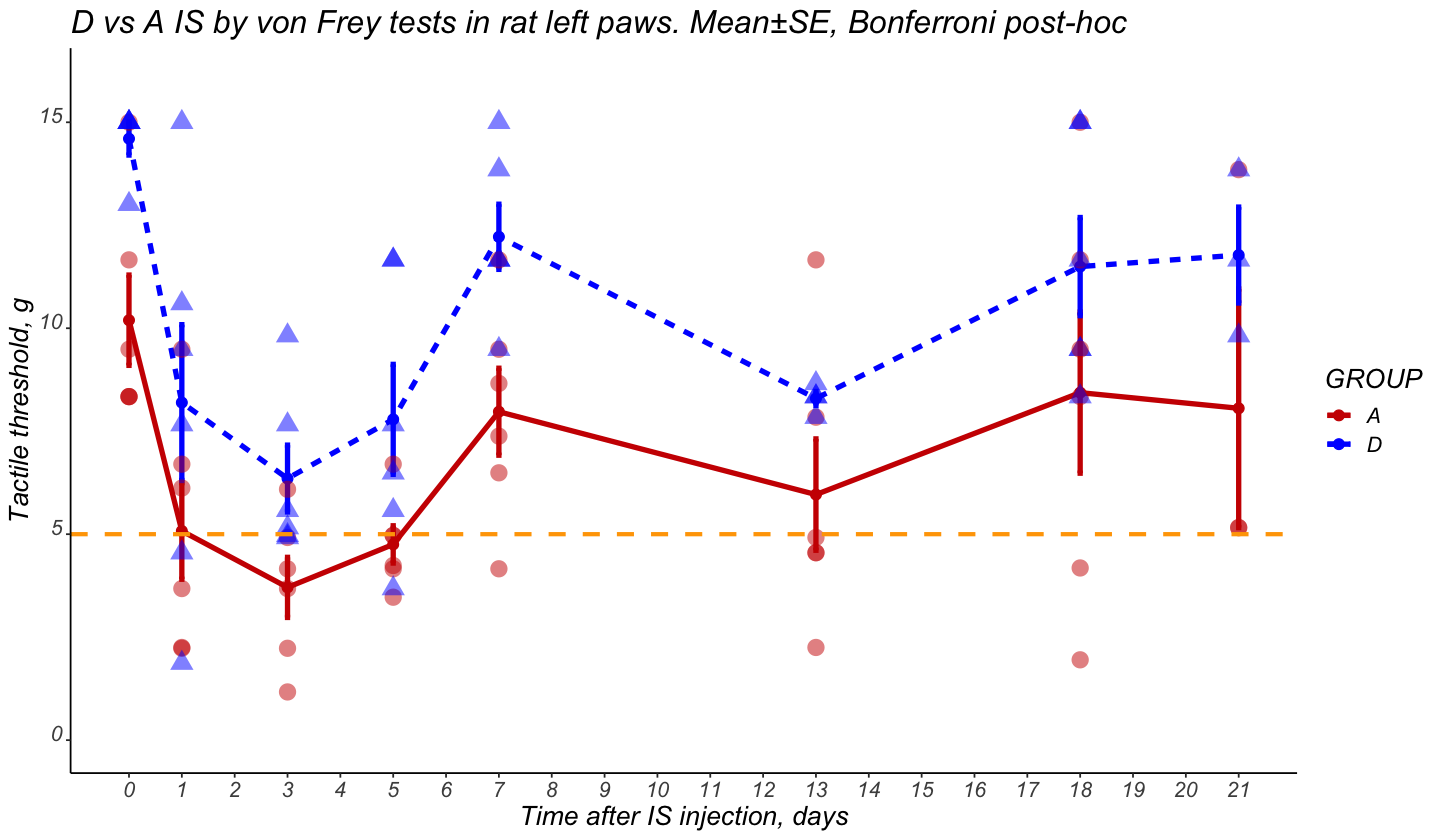

In [100]:
acPage(w1=12, h1=7)

for (i in 1:nrow(meta)){

lp_plot <- lp %>% filter ( GROUP == meta$TREATMENT[i] | GROUP == meta$REFERENCE[i] ) 
pwc.f <- pwc %>% filter(group1 == meta$TREATMENT[i] & group2 == meta$REFERENCE[i])
    
pp <- ggline(
            lp_plot, 
            y = "RESULT", 
            x = "TIMEPOINT", 
            color = "GROUP", 
            ylim = c(0, max_res + 1),
            linetype = "GROUP",
            size = 1.5, binwidth=0.1, 
            add = c("mean_se"),
            palette = c("red3", "blue1"),
            ) +  scale_x_continuous(breaks = 0:21*1) +
    stat_pvalue_manual( 
            pwc.f, 
            label = "p.adj.signif",
            position = position_dodge(0.6), 
            remove.bracket = T,
            size = 11,
            y.position = 15.5,
            hide.ns = T,
            color = "black"
            ) +
    geom_point(aes(shape = GROUP, color = GROUP, size = 10), alpha = 5/10, show.legend = F) +
    xlab(label = "Time after IS injection, days") +
    ylab(label = "Tactile threshold, g") +
    ggtitle( sprintf( "%s vs %s IS by von Frey tests in %s %s paws. Mean\u00B1SE, %s post-hoc", 
                     meta$TREATMENT[i], meta$REFERENCE[i], species, tolower (paw), str_to_title(post_hoc_method))) +
    theme_classic() +
    geom_hline(yintercept=pain_threshold, linetype="dashed", color = "orange", size=1.2) +
    theme(text = element_text(size=16, color = "black", angle = 0, hjust = .5, vjust = 0, face = "italic")) +
    geom_text(aes(label=ifelse(label_id & RESULT<=pain_threshold,as.character(ANIMAL_ID),'')),hjust = 0, vjust = 1.5, size = 4)

    plot(pp)

    pdf(sprintf("vonFrey plot %s vs %s in %s %s paw.pdf", meta$TREATMENT[i], meta$REFERENCE[i], species, tolower (paw)), width = 12, height = 7)
        plot(pp)
    dev.off()
}

In [101]:
for (i in 1:nrow(meta)){
sprintf("Significance scores for %s vs %s, post-hoc %s", meta$TREATMENT[i], meta$REFERENCE[i], post_hoc_method) %>% print
pwc %>% filter(group1 == meta$TREATMENT[i] & group2 == meta$REFERENCE[i]) %>% 
    mutate (DAY = as.integer(DAY)) %>% 
    arrange (DAY) %>% 
    select (DAY, group1, group2, p, p.adj, p.adj.signif) %>%
    print
}
pwc <- pwc %>% arrange (group1, group2, DAY) %>% print

[1] "Significance scores for B vs E, post-hoc bonferroni"
# A tibble: 8 × 6
    DAY group1 group2          p     p.adj p.adj.signif
  <int> <chr>  <chr>       <dbl>     <dbl> <chr>       
1     0 B      E      0.364      1         ns          
2     1 B      E      0.00000554 0.0000332 ****        
3     3 B      E      0.00820    0.0492    *           
4     5 B      E      0.494      1         ns          
5     7 B      E      0.0194     0.116     ns          
6    13 B      E      0.000867   0.00520   **          
7    18 B      E      0.00984    0.0591    ns          
8    21 B      E      0.0315     0.189     ns          
[1] "Significance scores for B vs A, post-hoc bonferroni"
# A tibble: 8 × 6
    DAY group1 group2     p p.adj p.adj.signif
  <int> <chr>  <chr>  <dbl> <dbl> <chr>       
1     0 B      A      0.355     1 ns          
2     1 B      A      0.998     1 ns          
3     3 B      A      0.482     1 ns          
4     5 B      A      0.231     1 ns          
5     

### Write results in file with **Results.** prefix

In [102]:
write_xlsx(list(data = x, meta = meta, stats = pwc), res_file)